### This notebook visualizes a csv result of tfr_evaluate.py

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats 
import h5py
import loss
from tensorflow.python.keras import backend as K
from modelzoo import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

In [40]:
performance_results = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_48.csv')
eval_type = 'whole'
pred_type = 'raw'

raw_whole_perf = performance_results[(performance_results['eval type']==eval_type)&
                                    (performance_results['pred type']==pred_type)&
                                    (performance_results['bin_size']==1)]


descriptions = raw_whole_perf.iloc[:,7:]
avg_perf = raw_whole_perf.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')
avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete.data_dir]
df = avg_perf_complete[['model_fn', 'pr_corr', 'mse', 'crop', 'rev_comp_x', 'dataset']].sort_values('model_fn')
print(df.sort_values('pr_corr'))



    model_fn   pr_corr       mse    crop  rev_comp_x        dataset
60     bpnet  0.525689  0.878199   False       False  peak centered
195    bpnet  0.525900  0.883524   False       False  peak centered
315    bpnet  0.526616  0.885403   False       False  peak centered
255    bpnet  0.556950  0.835128  r_crop       False  peak centered
135    bpnet  0.559192  0.837584  r_crop       False  peak centered
15     bpnet  0.562782  0.836817  r_crop       False  peak centered
300    bpnet  0.563519  0.834734   False        True  peak centered
180    bpnet  0.564012  0.804460   False        True  peak centered
75     bpnet  0.566093  0.799411   False        True  peak centered
285    bpnet  0.577636  0.693254  r_crop       False    random chop
165    bpnet  0.578547  0.692565  r_crop       False    random chop
30     bpnet  0.580767  0.690883  r_crop       False    random chop
225    bpnet  0.586001  0.685079   False       False    random chop
105    bpnet  0.588704  0.681719   False       F

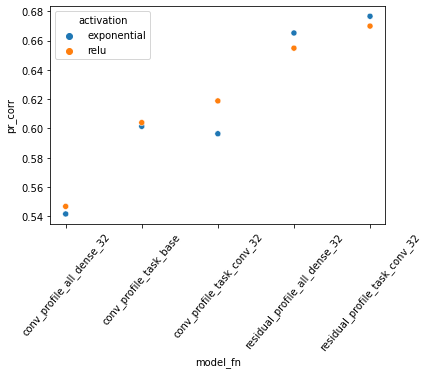

In [16]:
performance_results = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/32_res.csv')
eval_type = 'whole'
pred_type = 'raw'

raw_whole_perf = performance_results[(performance_results['eval type']==eval_type)&
                                    (performance_results['pred type']==pred_type)]

descriptions = raw_whole_perf.iloc[:,7:]
avg_perf = raw_whole_perf.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')

sns.scatterplot(data=avg_perf_complete[['activation', 'model_fn', 'pr_corr', 'mse']].sort_values('model_fn'),
               x='model_fn', y='pr_corr', hue='activation')

plt.xticks(rotation=50);


     activation                    model_fn   pr_corr       mse
0   exponential      conv_profile_task_base  0.598819  0.678551
45         relu      conv_profile_task_base  0.607010  0.657293
30  exponential   residual_profile_all_base  0.655211  0.587083
75         relu   residual_profile_all_base  0.641600  0.610693
15  exponential  residual_profile_task_base  0.653638  0.590186
60         relu  residual_profile_task_base  0.636879  0.622225


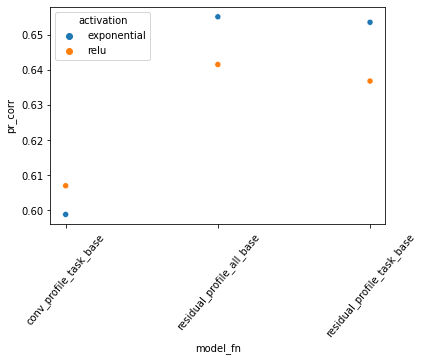

In [41]:
performance_results = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/base_res.csv')
eval_type = 'whole'
pred_type = 'raw'

raw_whole_perf = performance_results[(performance_results['eval type']==eval_type)&
                                    (performance_results['pred type']==pred_type)]

descriptions = raw_whole_perf.iloc[:,7:]
avg_perf = raw_whole_perf.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')

df = avg_perf_complete[['activation', 'model_fn', 'pr_corr', 'mse']].sort_values('model_fn')
sns.scatterplot(data=df,
               x='model_fn', y='pr_corr', hue='activation')

plt.xticks(rotation=50);
print(df)


In [45]:
avg_perf_complete[['model_fn', 'activation', 'run_dir']]

,model_fn,activation,run_dir
0,conv_profile_task_base,exponential,paper_runs/new_models/base_res/run-20211022_14...
15,residual_profile_task_base,exponential,paper_runs/new_models/base_res/run-20211022_14...
30,residual_profile_all_base,exponential,paper_runs/new_models/base_res/run-20211022_14...
45,conv_profile_task_base,relu,paper_runs/new_models/base_res/run-20211022_15...
60,residual_profile_task_base,relu,paper_runs/new_models/base_res/run-20211022_20...
75,residual_profile_all_base,relu,paper_runs/new_models/base_res/run-20211022_22...


In [55]:
avg_perf_complete[(avg_perf_complete['model_fn']=='residual_profile_task_base')&
                 (avg_perf_complete['activation']=='exponential')]['run_dir'].values

array(['paper_runs/new_models/base_res/run-20211022_140424-yc4sh7qf'],
      dtype=object)